# Colab google drive mount and tensorflow doc

In [ ]:
# Colab
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CZ4042 Assign 1')

!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-4waao4jt
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-4waao4jt
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184222 sha256=79129474bec9d25e7d84dba9addab5e07d2490faeb2b0ec4f65fd581c175ba0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-020zq_8e/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [ ]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [ ]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [ ]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [ ]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# ***Given codes above***
---
# ***My codes start here***

# Question 1

## Q1-a

In [ ]:
# Split data

# Use filter over dataframe
train_df = df[df['year'] <= 2020] # TODO
val_dataframe = df[df['year'] > 2020] # TODO

train_ds = dataframe_to_dataset(train_df)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)


Why is this done instead of using random train/test splits?
- The resale price is affected by time, if we don't split data by years (i.e. random split), when we predict the resale price of given labels, we might implicitly use the future information, which is not possible since the future knowledge shouldn't be used when you try to predict the past.

## Q1-b

In [ ]:
dtypes_dict = df.dtypes.apply(lambda x: x.name).to_dict()
for key, value in dtypes_dict.items():
  if value == 'object':
    dtypes_dict[key] = 'string'
dtypes_dict

{'month': 'int64',
 'year': 'int64',
 'full_address': 'string',
 'nearest_stn': 'string',
 'dist_to_nearest_stn': 'float64',
 'dist_to_dhoby': 'float64',
 'degree_centrality': 'float64',
 'eigenvector_centrality': 'float64',
 'flat_model_type': 'string',
 'remaining_lease_years': 'float64',
 'floor_area_sqm': 'float64',
 'storey_range': 'string',
 'resale_price': 'float64'}

Following Appendix A

In [ ]:
lookup = ['month', 'storey_range', 'flat_model_type']
normalization = ['floor_area_sqm', 'remaining_lease_years', 'degree_centrality', 'eigenvector_centrality', 'dist_to_nearest_stn', 'dist_to_dhoby']

In [ ]:
# Create input variables
def get_model():
  lookup_inputs = {}
  for key in lookup:
    lookup_inputs[key] = keras.Input(shape=(1,), name=key, dtype=dtypes_dict[key])

  normalization_inputs = {}
  for key in normalization:
    normalization_inputs[key] = keras.Input(shape=(1,), name=key, dtype=dtypes_dict[key])

  all_inputs_key = lookup + normalization
  all_inputs = [lookup_inputs[key] if key in lookup else normalization_inputs[key] for key in all_inputs_key]

  # Create output/encoded variables
  lookup_outputs = {}
  for key in lookup:
    lookup_outputs[key] = encode_categorical_feature(lookup_inputs[key], key, train_ds, dtypes_dict[key] == 'string')

  normalization_outputs = {}
  for key in normalization:
    normalization_outputs[key] = encode_numerical_feature(normalization_inputs[key], key, train_ds)
  
  # Concatenate all encoded outputs/features
  all_features = layers.concatenate([lookup_outputs[key] if key in lookup else normalization_outputs[key] for key in all_inputs_key])

  output = layers.Dense(1)(all_features)
  model = keras.Model(all_inputs, output)
  return model


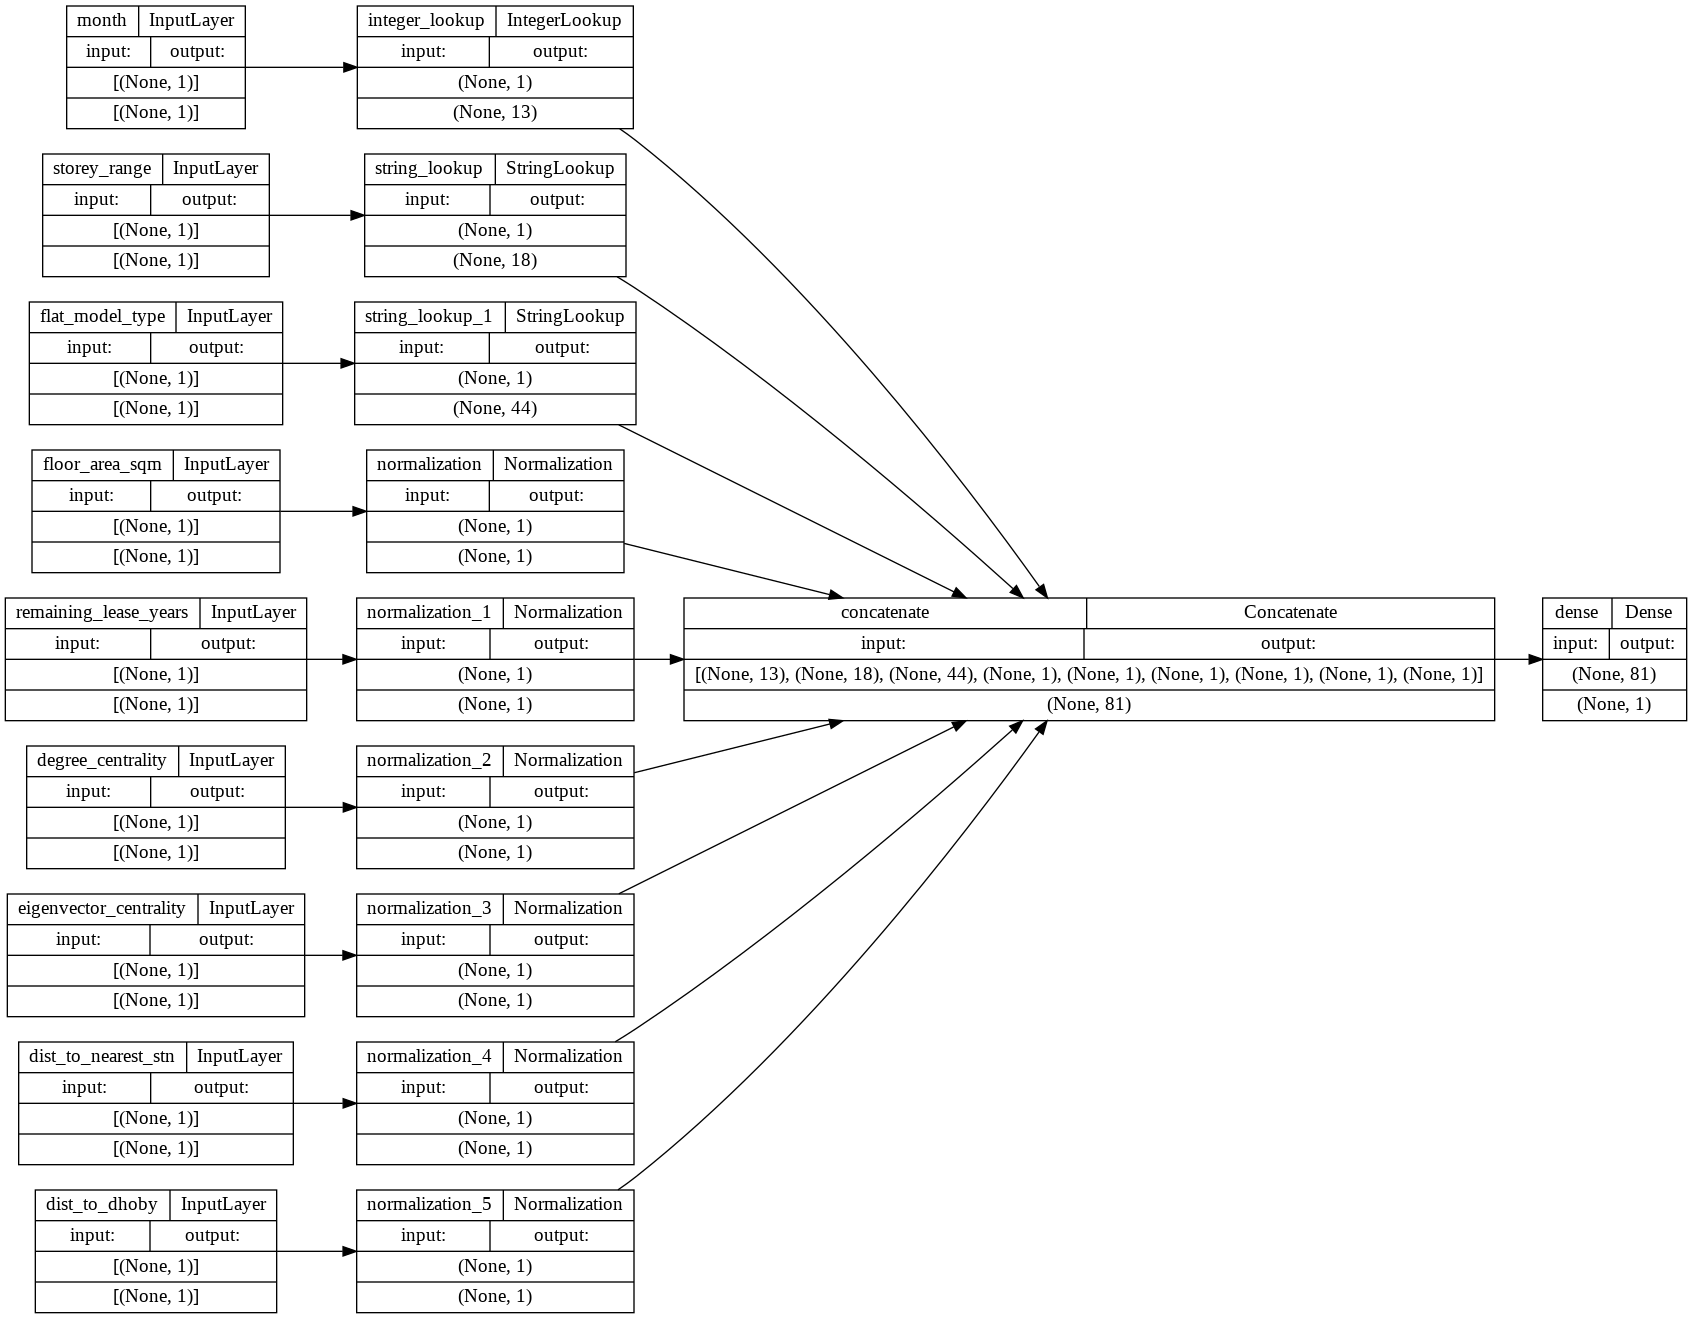

In [ ]:
model = get_model()
# see the architecture
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Q1-c

In [ ]:
# record training history
histories = {}

Firstly, train as suggested:

In [ ]:
epoch_num = 50
# batch size is set to 256 in Question 1
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'mse', metrics = [r2])

history = model.fit(
    train_ds,
    epochs = epoch_num,
    validation_data = val_ds,
    verbose = 0
)
histories['Q1-c-Adam'] = history
print(f"The test r2 value is { history.history['val_r2'][-1] }")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


The test r2 value is -10.073880195617676


Now, change the optimizer to SGD and greater learning rate

In [ ]:
model = get_model()
model.compile(optimizer = keras.optimizers.SGD(learning_rate=0.01), loss = 'mse', metrics = [r2])
history = model.fit(
    train_ds,
    epochs = epoch_num,
    validation_data = val_ds,
    verbose = 0
)
histories['Q1-c-SGD'] = history
print(f"The test r2 value is { history.history['val_r2'][-1] }")

The test r2 value is 0.6110846400260925


Compared with `SGD`, the learning rate of `Adam` is updated along the training, which might cause the learning rate too small to optimize the model.

## Q1-d

In [ ]:
# Create input variables
def get_model_Q1_d():
  lookup_inputs = {}
  for key in lookup:
    lookup_inputs[key] = keras.Input(shape=(1,), name=key, dtype=dtypes_dict[key])

  normalization_inputs = {}
  for key in normalization:
    normalization_inputs[key] = keras.Input(shape=(1,), name=key, dtype=dtypes_dict[key])

  all_inputs_key = lookup + normalization
  all_inputs = [lookup_inputs[key] if key in lookup else normalization_inputs[key] for key in all_inputs_key]

  # Create output/encoded variables
  lookup_outputs = {}
  for key in lookup:
    lookup_outputs[key] = encode_categorical_feature(lookup_inputs[key], key, train_ds, dtypes_dict[key] == 'string')

  normalization_outputs = {}
  for key in normalization:
    normalization_outputs[key] = encode_numerical_feature(normalization_inputs[key], key, train_ds)
  
  # Concatenate all encoded outputs/features
  all_features = layers.concatenate([lookup_outputs[key] if key in lookup else normalization_outputs[key] for key in all_inputs_key])

  hidden = layers.Dense(10, activation = 'relu')(all_features)
  output = layers.Dense(1)(hidden)
  model = keras.Model(all_inputs, output)
  return model


In [ ]:
model = get_model_Q1_d()
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
histories = {}

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.08), loss = 'mse', metrics = [r2])
history = model.fit(
    train_ds,
    epochs = epoch_num,
    validation_data = val_ds,
    verbose = 0
)
histories['Q1-d'] = history
print(f"The test r2 value is { history.history['val_r2'][-1] }")

The test r2 value is 0.6578726172447205


## Q1-e

Q1d has a better performance than Q1c. The hidden layer in Q1d increases the nonlinearity of the model as well as the capacity, which makes it fit the data better.

# Question 2

## Q2-a

In [ ]:
# Split data

# Use filter over dataframe
train_df = df[df['year'] < 2020] 
val_dataframe = df[df['year'] == 2020]
test_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_df)
val_ds = dataframe_to_dataset(val_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)
test_ds = test_ds.batch(256)

## Q2-b

In [ ]:
def encode_categorical_feature_Q2_b(feature, name, dataset, is_string, divisor):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.
    
    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # embedding
    input_sz = lookup.vocabulary_size()
    embedding = tf.keras.layers.Embedding(input_sz, input_sz//divisor)

    # Turn the string input into integer indices
    embedded_feature = embedding(lookup(feature))
    encoded_feature = tf.keras.layers.Flatten()(embedded_feature)
    return encoded_feature

# Create input variables
def get_model_Q2_b(num_dense, divisor):
  lookup_inputs = {}
  for key in lookup:
    lookup_inputs[key] = keras.Input(shape=(1,), name=key, dtype=dtypes_dict[key])

  normalization_inputs = {}
  for key in normalization:
    normalization_inputs[key] = keras.Input(shape=(1,), name=key, dtype=dtypes_dict[key])

  all_inputs_key = lookup + normalization
  all_inputs = [lookup_inputs[key] if key in lookup else normalization_inputs[key] for key in all_inputs_key]

  # Create output/encoded variables
  lookup_outputs = {}
  for key in lookup:
    lookup_outputs[key] = encode_categorical_feature_Q2_b(lookup_inputs[key], key, train_ds, dtypes_dict[key] == 'string', divisor)

  normalization_outputs = {}
  for key in normalization:
    normalization_outputs[key] = encode_numerical_feature(normalization_inputs[key], key, train_ds)
  
  # Concatenate all encoded outputs/features
  all_features = layers.concatenate([lookup_outputs[key] if key in lookup else normalization_outputs[key] for key in all_inputs_key])

  hidden = layers.Dense(num_dense, activation = 'relu')(all_features)
  output = layers.Dense(1)(hidden)
  model = keras.Model(all_inputs, output)
  return model


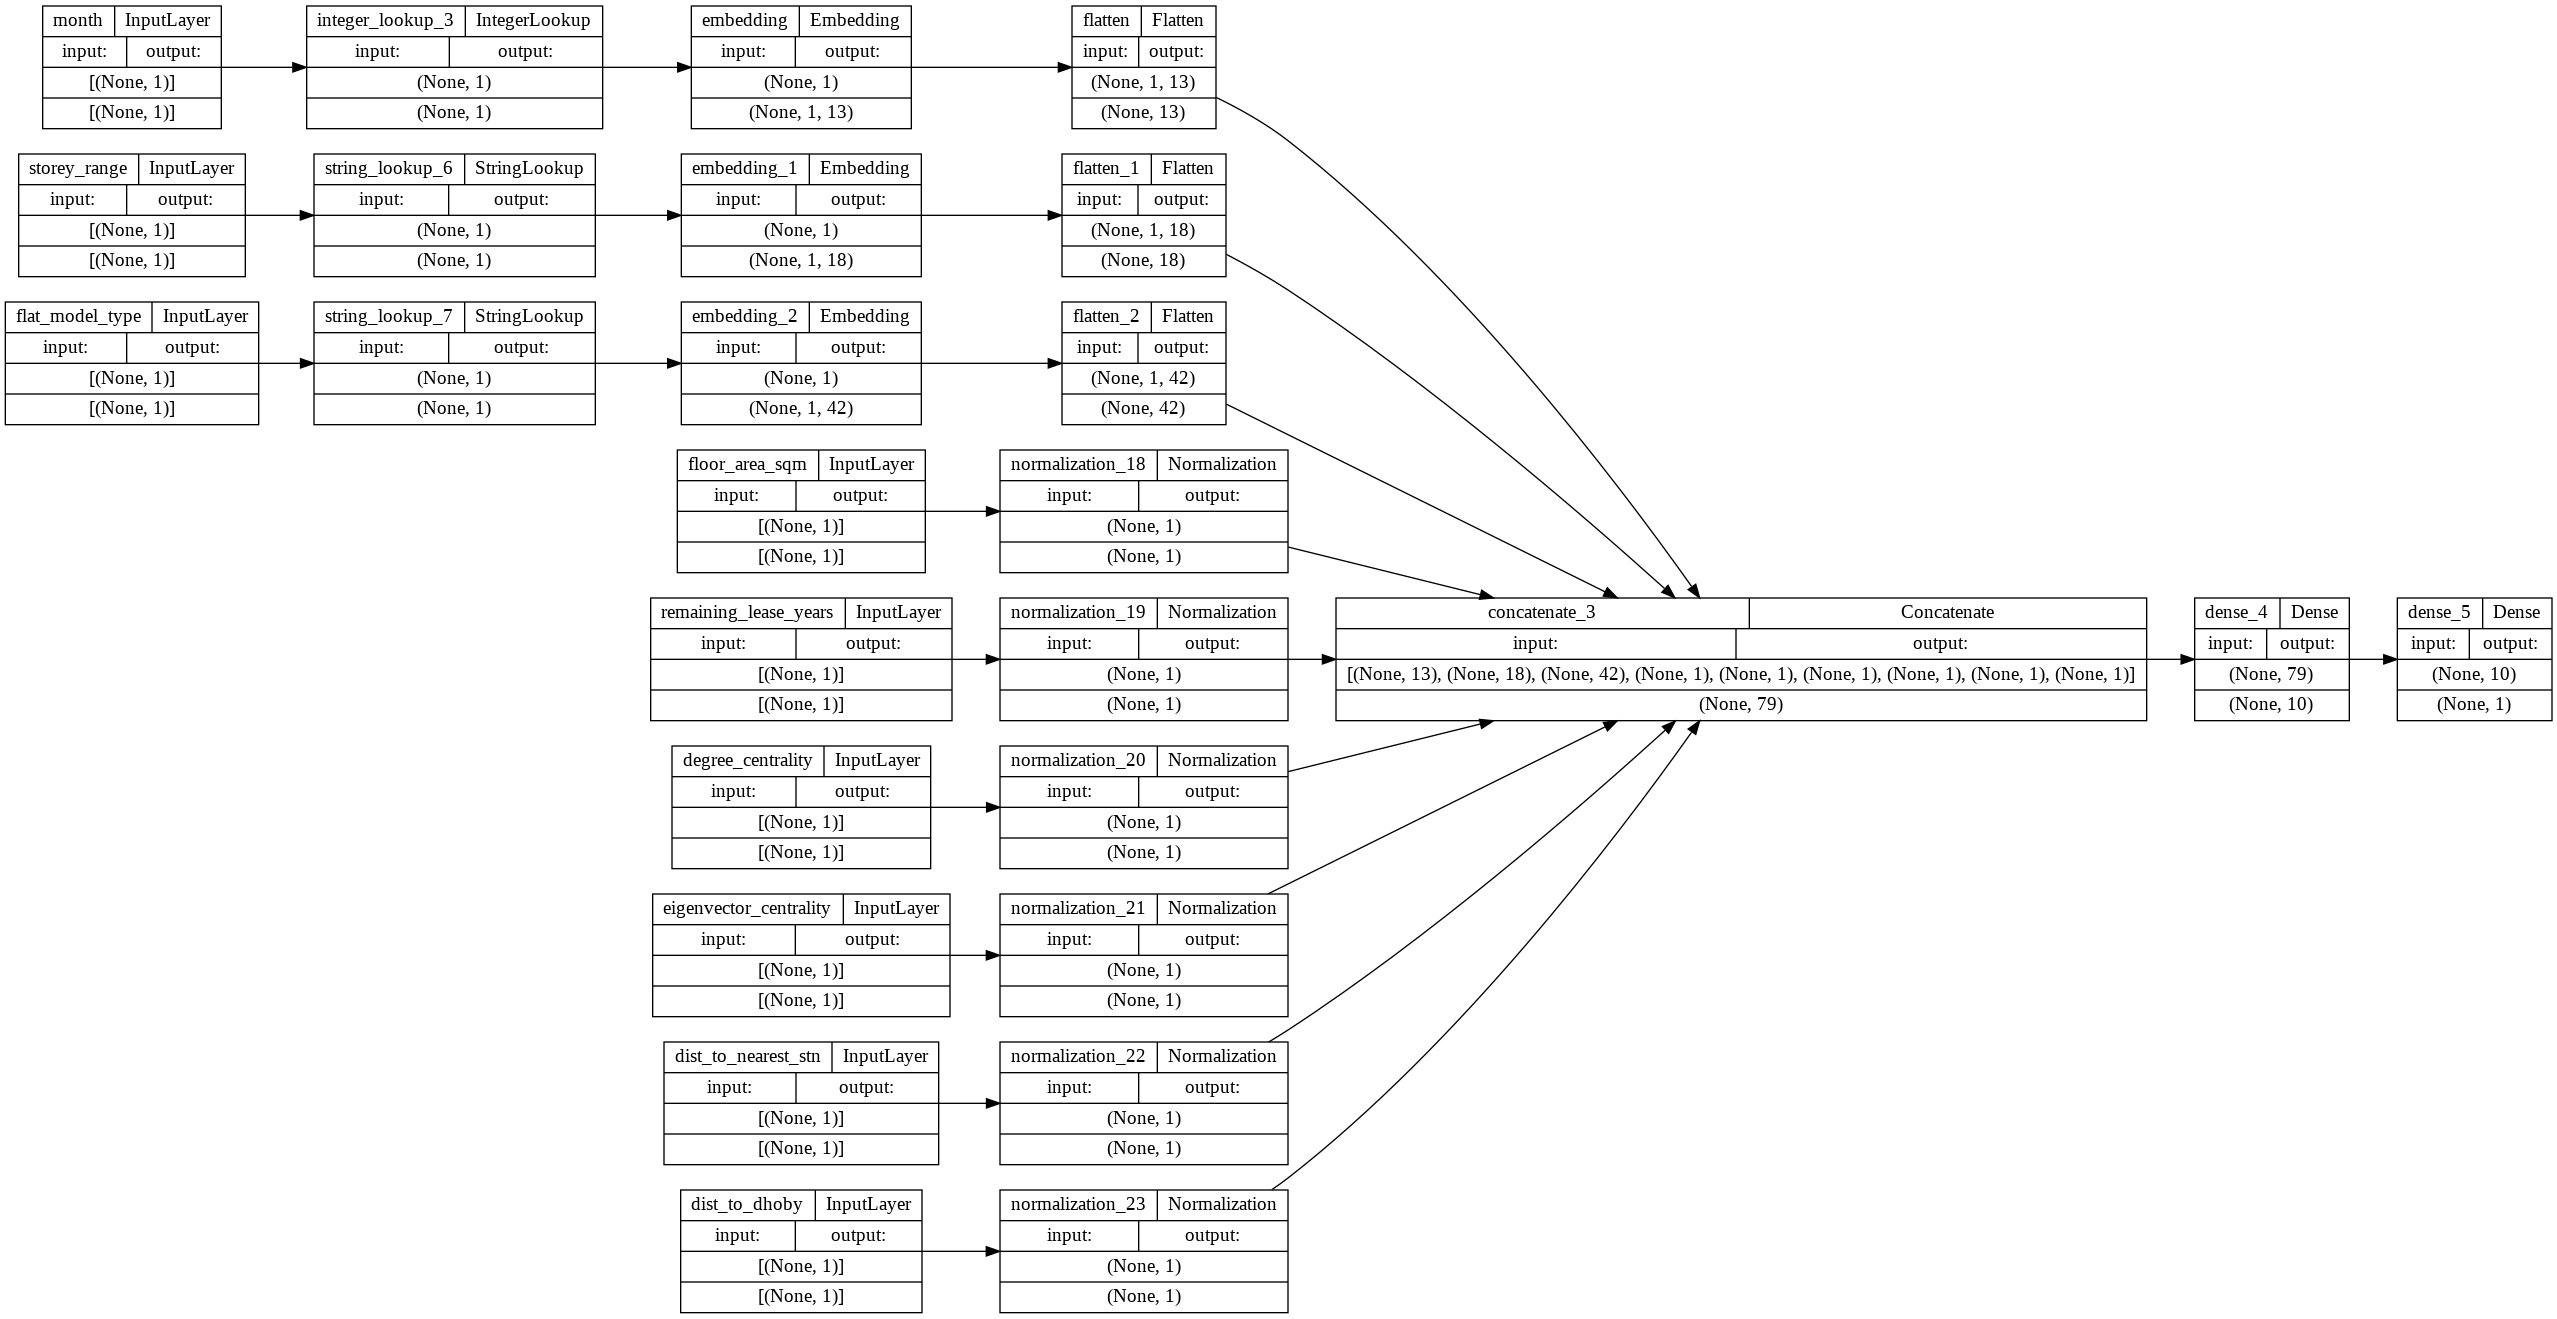

In [ ]:
model = get_model_Q2_b(10, 1)
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Q2-c

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)]

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner

     |████████████████████████████████| 135 kB 36.3 MB/s 
     |████████████████████████████████| 1.6 MB 48.9 MB/s 


In [ ]:
def call_existing_code(num_neurons, divisor, lr):
  model = get_model_Q2_b(num_neurons, divisor)
  opt = keras.optimizers.Adam(learning_rate=lr)
  model.compile(optimizer = opt, loss = 'mse')
  return model

def build_model(hp):
  num_neurons = hp.Int("num_neurons", min_value=4, max_value=32, step=4)
  lr = hp.Float("lr", min_value=1e-4, max_value=2e-1, sampling="log")
  divisor = hp.Int("divisor", min_value=1, max_value=2, step=1)
  return call_existing_code(num_neurons, divisor, lr)

In [ ]:
tuner = keras_tuner.RandomSearch(
  build_model,
  objective='val_loss',
  max_trials=10
  )
tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks = callbacks, verbose = 0)

In [ ]:
best_model = tuner.get_best_models()[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

In [ ]:
best_hyperparameters.values

{'lr': 0.07341006871139777, 'num_neurons': 24, 'divisor': 1}

## Q2-d

In [ ]:
num_neurons = best_hyperparameters.values['num_neurons']
lr = best_hyperparameters.values['lr']
divisor = best_hyperparameters.values['divisor']

# update train_ds
train_df = df[df['year'] <= 2020]
train_ds = dataframe_to_dataset(train_df)
train_ds = train_ds.batch(256)

model = get_model_Q2_b(num_neurons, divisor)

In [ ]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint('./ckpt', monitor = 'val_loss', save_best_only = True)
callbacks.append(ckpt_callback)
model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr), loss = 'mse', metrics = [tf.keras.metrics.RootMeanSquaredError(), r2])
histories = {}
history = model.fit(train_ds, epochs = 50, validation_data = test_ds, callbacks = callbacks, verbose = 0)
histories['Q2-d'] = history

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


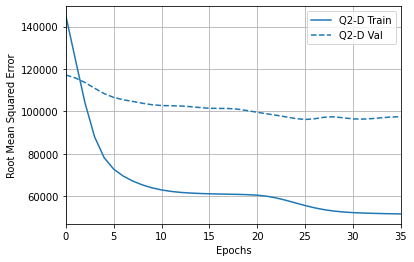

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'root_mean_squared_error', smoothing_std=10)
plotter.plot(histories)

## Q2-e

In [ ]:
model = tf.keras.models.load_model('./ckpt', custom_objects={'r2': r2})
print(f"The r2 from the best epoch is {model.evaluate(test_ds)[-1]}")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 1s 5ms/step - loss: 8051558912.0000 - root_mean_squared_error: 89730.4766 - r2: 0.7042
The r2 from the best epoch is 0.7042470574378967


In [ ]:
X = test_dataframe.copy()
y = X.pop('resale_price').to_numpy().reshape([-1, 1])
y_hat = model.predict(dict(X))
predict_err = abs(y - y_hat)
test_dataframe['predict'] = y_hat
test_dataframe['err'] = predict_err

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test_dataframe.sort_values('err', ascending = False).head(30)

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price,predict,err
114504,12,2021,6 TOH YI DRIVE,Beauty World,0.428356,8.948410,0.016807,0.001358,"EXECUTIVE, Maisonette",66.666667,154.0,04 TO 06,1238000.0,783816.0000,454184.0000
119399,5,2022,96A HENDERSON ROAD,Tiong Bahru,0.586629,2.932814,0.016807,0.047782,"5 ROOM, Improved",96.083333,113.0,40 TO 42,1400000.0,961654.4375,438345.5625
120164,1,2022,2 TOH YI DRIVE,Beauty World,0.271583,9.003026,0.016807,0.001358,"EXECUTIVE, Maisonette",65.666667,146.0,07 TO 09,1202000.0,769463.0625,432536.9375
114505,12,2021,7 TOH YI DRIVE,Beauty World,0.473544,8.936025,0.016807,0.001358,"EXECUTIVE, Apartment",66.750000,142.0,04 TO 06,1125000.0,693889.8750,431110.1250
117107,7,2022,104A ANG MO KIO STREET 11,Ang Mo Kio,1.216557,8.071776,0.016807,0.006243,"EXECUTIVE, Apartment",72.833333,146.0,04 TO 06,1120000.0,689016.8125,430983.1875
117054,4,2022,260A ANG MO KIO STREET 21,Ang Mo Kio,1.722450,7.861222,0.016807,0.006243,"5 ROOM, Improved",95.166667,113.0,28 TO 30,1150000.0,727339.5625,422660.4375
117058,6,2022,260A ANG MO KIO STREET 21,Ang Mo Kio,1.722450,7.861222,0.016807,0.006243,"5 ROOM, Improved",95.083333,113.0,19 TO 21,1100000.0,678769.3750,421230.6250
119400,5,2022,96A HENDERSON ROAD,Tiong Bahru,0.586629,2.932814,0.016807,0.047782,"5 ROOM, Improved",96.083333,113.0,46 TO 48,1380000.0,962822.5000,417177.5000
127227,8,2022,86 DAWSON ROAD,Queenstown,0.489478,3.977493,0.016807,0.008342,"5 ROOM, Premium Apartment",93.083333,104.0,13 TO 15,1181000.0,767882.3750,413117.6250
125026,8,2022,14 MARINE TERRACE,Kembangan,1.949971,7.761923,0.016807,0.002799,"5 ROOM, Standard",51.500000,120.0,13 TO 15,938000.0,526714.4375,411285.5625


1. `nearest_stn` is mainly `Ang Mo Kio` and `Beauty World`.
2. `flat_model_type` is mainly `5 ROOM, Improved` or contains `EXECUTIVE`.
3. `resale_price` is above/around 1000000.

- Collect more training data with above features.
- Do normalization with current data.
- Try to find a better model.

# Question 3

## Q3-a

In [ ]:
df_old = pd.read_csv('hdb_price_prediction_old.csv')

df_dict = {}
df_dict['2021_old'] = df_old[df_old['year'] == 2021]
df_dict['2021'] = df[df['year'] == 2021]
df_dict['2022'] = df[df['year'] == 2022]

for key, _df in df_dict.items():
  _ds = dataframe_to_dataset(_df)
  _ds = _ds.batch(256)
  metrics = model.evaluate(_ds, verbose = 0)
  print(f"Test r2 error of {key} is {metrics[-1]}")

Test r2 error of 2021_old is 0.8286476135253906
Test r2 error of 2021 is 0.793515682220459
Test r2 error of 2022 is 0.5562084317207336


## Q3-b

The extent of degradation of the both models my model is greater. This might be because the larger capacity and non-linear activation, and my model tends to:
  - "Remember" the trainning pattern.
  - Overfit

And since has worse robustness (tends to be affected by data shift).

## Q3-c

In [ ]:
import matplotlib.pyplot as plt

Categoricl features except `year`, `full_address` have similar pie charts.
Numerical features `remaining_lease_years` has distinguishable shifts.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'remaining_lease_years')

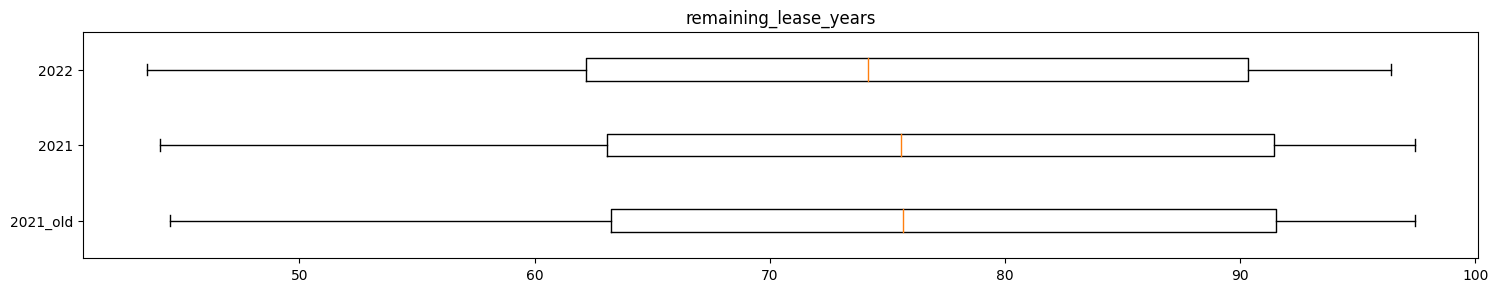

In [ ]:
remaining_lease_years = {}
for key, _df in df_dict.items():
  remaining_lease_years[key] = _df['remaining_lease_years'].to_numpy()
labels, data = [*zip(*remaining_lease_years.items())]
plt.figure(figsize=(18, 3), dpi = 100)
statics = plt.boxplot(data, vert = False)
plt.yticks(range(1, len(labels) + 1), labels)
plt.title('remaining_lease_years')

In [ ]:
import matplotlib.pyplot as plt

Label shifts:

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'resale_price')

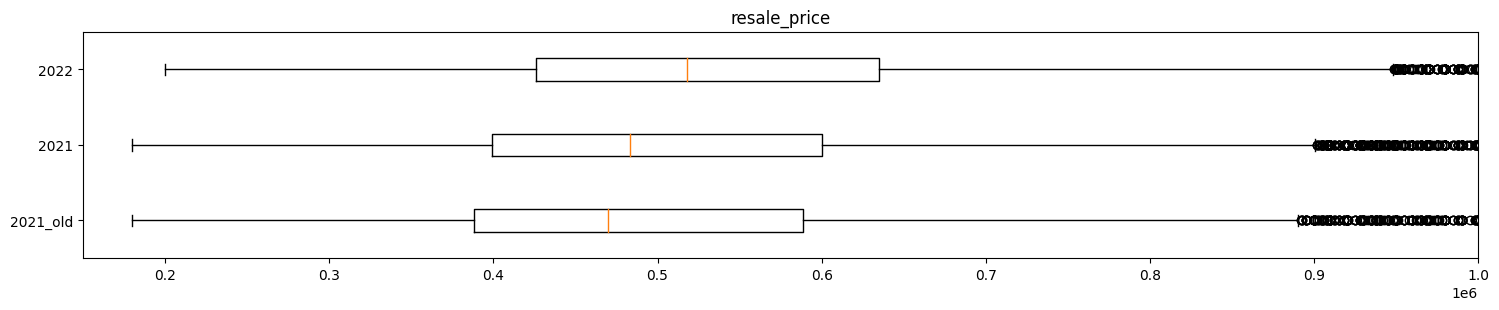

In [ ]:
resale_prices = {}
for key, _df in df_dict.items():
  resale_prices[key] = _df['resale_price'].to_numpy()
labels, data = [*zip(*resale_prices.items())]
plt.figure(figsize=(18, 3), dpi = 100)
statics = plt.boxplot(data, vert = False)
plt.yticks(range(1, len(labels) + 1), labels)
plt.xlim(150000, 1000000)
plt.title('resale_price')

## Q3-d

In [ ]:
"""
Implementation of recursive feature elimination algorithm for neural networks.

Recursive feature elimination (RFE) is a feature selection method that removes unnecessary features from the inputs. 
It can also shed some insights on how much each feature contributes to the prediction task.

The algorithm starts by removing one input feature whose removal leads to the minimum drop (or maximum improvement) in performance. 
- Given k features, to determine which of the k features will cause the minimum drop / maximum increase when that feature is removed, you will have to perform k experiments. After removing that feature, k-1 features will be left and you will have to perform k-1 experiments to determine the next feature to remove.
    - In the case removing a feature leads to an improvement from the baseline (all features used), that feature is likely not useful since removing it actually helped the model to perform better.
    - There will also be cases when all subsets with k-1 features do not do better than the baseline model. In that case, it is likely that all features are useful. You can get a sense of which are more useful than others by looking at the increase in error that occurs when the feature is removed.

This procedure is repeated recursively on the reduced input set until the optimal number of input features is reached. 
- The feature removal goes on until either 1 feature is left, or the model performance does not improve from the previous best (e.g. when there are 7 features left, if none of the 7 experiments performed does better than the best performance of the model with 8 features, the RFE algorithm terminates).
- The condition to stop the recursive process once all (k-1)-features models do worse than the best k-features model was added to make the algorithm terminate earlier so that you don't have to run too many iterations. Also, if the condition happens, then subsequent search is likely to be fruitless (it's always possible for the contrary to happen, but the chances are low and it's usually not worth the additional time).

Each model should use a different subset of features and they are trained independently. There is no loading of weights from any previous models.


In the code below, a boolean mask `vec` is used to keep track of which features to select during the iteration. 

You need to place your model training code into the 'train_model' function and have it return the validation loss.

Look out for the comments labelled 'TODO'.

"""

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)


import time
start = time.time()

num_features = 9

vec = [1 for i in range(num_features)]
best_loss = 1e15
new_best_loss = 1e14
which_iter = ''

all_losses = [] # should be len 9,8,7,...


def train_model(feature_mask):
    """
    Given a boolean mask (feature_mask), select the features accordingly, train the model and return the validation loss.
    """
    
    feature_mask_string = ''.join([str(i) for i in feature_mask])
    
    # TODO: define the input layer here (your code from Q2)
    #######################################################
    lookup_inputs = {}
    for key in lookup:
      lookup_inputs[key] = keras.Input(shape=(1,), name=key, dtype=dtypes_dict[key])

    normalization_inputs = {}
    for key in normalization:
      normalization_inputs[key] = keras.Input(shape=(1,), name=key, dtype=dtypes_dict[key])

    all_inputs_key = lookup + normalization
    all_inputs = [lookup_inputs[key] if key in lookup else normalization_inputs[key] for key in all_inputs_key]

    # Create output/encoded variables
    lookup_outputs = {}
    for key in lookup:
      lookup_outputs[key] = encode_categorical_feature_Q2_b(lookup_inputs[key], key, train_ds, dtypes_dict[key] == 'string', divisor)

    normalization_outputs = {}
    for key in normalization:
      normalization_outputs[key] = encode_numerical_feature(normalization_inputs[key], key, train_ds)
    
    # Concatenate all encoded outputs/features
    all_features_input = [lookup_outputs[key] if key in lookup else normalization_outputs[key] for key in all_inputs_key]

    #######################################################
    
    selected_inputs = []
    print('going through feature_mask', feature_mask)
    for i,j in zip(all_features_input, feature_mask):
        if j == 1:
            selected_inputs.append(i)
            print(i)
        else:
            print('Skipping', i)

    all_features = layers.concatenate(selected_inputs)
    
    # TODO: Complete the rest of the architecture + training code and retrieve the training history
    #######################################################


    hidden = layers.Dense(10, activation = 'relu')(all_features)
    output = layers.Dense(1)(hidden)
    model = keras.Model(all_inputs, output)

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr), loss = 'mse', metrics = [tf.keras.metrics.RootMeanSquaredError(), r2])
    his = model.fit(train_ds, epochs = 50, validation_data = test_ds, callbacks = callbacks, verbose = 0)
    #######################################################

    val_loss_hx = his.history['val_loss'] # NOTE: You can use RMSE if you find it easier to interpret.
    val_loss_min = min(val_loss_hx)
    
    return val_loss_min


## RFE starts here 

while sum(vec) > 0 and best_loss > new_best_loss:
    
    print('vec', vec)

    best_loss = new_best_loss
    new_min_loss_flag = False
    
    losses_from_same_vec = []
    
    for ix, i in enumerate(vec):
        
        print('ix', ix, 'i', i)
        
        if i == 0:
            continue # if the feature is off, no need to do anything, go to next position
        else:
            temp_vec = vec[:]
            temp_vec[ix] = 0 # turn off the feature
            print('updated temp_vec', temp_vec)
            
            loss = train_model(temp_vec)
            losses_from_same_vec.append(loss)
            
            if loss < new_best_loss:
                new_best_loss = loss
                which_iter = 'len ' + str(sum(vec)) + ', ix ' + str(ix)
                print('new min loss:', which_iter)
                new_min_loss_flag = True
                min_loss_vec = temp_vec[:]

            tf.keras.backend.clear_session()
            print('session cleared!\n')
                
    
    all_losses.append(losses_from_same_vec)
    
    # After going through the vec once, update vec if new min loss    
    if new_min_loss_flag:
        vec = min_loss_vec
    
    # else case means no new min loss, the latter while loop condition will cause it to terminate 
    print(time.time() - start, 'seconds elapsed')
    print()

print(all_losses)

vec [1, 1, 1, 1, 1, 1, 1, 1, 1]
ix 0 i 1
updated temp_vec [0, 1, 1, 1, 1, 1, 1, 1, 1]
going through feature_mask [0, 1, 1, 1, 1, 1, 1, 1, 1]
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), name='flatten_6/Reshape:0', description="created by layer 'flatten_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), name='flatten_7/Reshape:0', description="created by layer 'flatten_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 44), dtype=tf.float32, name=None), name='flatten_8/Reshape:0', description="created by layer 'flatten_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_12/truediv:0', description="created by layer 'normalization_12'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_13/truediv:0', description="created by layer 'normalization_13'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


new min loss: len 9, ix 0
session cleared!

ix 1 i 1
updated temp_vec [1, 0, 1, 1, 1, 1, 1, 1, 1]
going through feature_mask [1, 0, 1, 1, 1, 1, 1, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), name='flatten_1/Reshape:0', description="created by layer 'flatten_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 44), dtype=tf.float32, name=None), name='flatten_2/Reshape:0', description="created by layer 'flatten_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization/truediv:0', description="created by layer 'normalization'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_1/truediv:0', description="created by layer 'normalization_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.

In [ ]:
min_loss_id = [0, 0]
for i in range(len(all_losses)):
  for j in range(len(all_losses[i])):
    if all_losses[i][j] < all_losses[min_loss_id[0]][min_loss_id[1]]:
      min_loss_id[0] = i
      min_loss_id[1] = j
min_loss_id

[0, 0]

In [ ]:
all_inputs = lookup + normalization
all_inputs

['month',
 'storey_range',
 'flat_model_type',
 'floor_area_sqm',
 'remaining_lease_years',
 'degree_centrality',
 'eigenvector_centrality',
 'dist_to_nearest_stn',
 'dist_to_dhoby']

The minimum loss corresponding `feature_mask` is `[0, 1, 1, 1, 1, 1, 1, 1, 1]`.

The masked feature is `month`.

The best feature subset is [`storey_range`, `flat_model_type`, `floor_area_sqm`, `remaining_lease_years`, `degree_centrality`, `eigenvector_centrality`, `dist_to_nearest_stn`, `dist_to_dhoby`]

## Q3-e

In [ ]:
max_loss_id = [0, 0]
for i in range(len(all_losses)):
  for j in range(len(all_losses[i])):
    if all_losses[i][j] > all_losses[max_loss_id[0]][max_loss_id[1]]:
      max_loss_id[0] = i
      max_loss_id[1] = j
max_loss_id

[0, 8]

In [ ]:
second_max_loss_id = [0, 0]
for i in range(len(all_losses)):
  for j in range(len(all_losses[i])):
    if all_losses[i][j] < all_losses[max_loss_id[0]][max_loss_id[1]]:
      if all_losses[i][j] > all_losses[second_max_loss_id[0]][second_max_loss_id[1]]:
        second_max_loss_id[0] = i
        second_max_loss_id[1] = j
second_max_loss_id

[1, 7]

The max loss corresponding `feature_mask` is `[1, 1, 1, 1, 1, 1, 1, 1, 0]`.

The masked feature is `dist_to_dhoby`.

The 2nd max loss corresponding `feature_mask` is `[0, 1, 1, 1, 1, 1, 1, 0, 1]`.

The masked feature is `dist_to_nearest_stn`.

As we can see:
- `dist_to_nearset_stn` and `dist_to_dhoby` are still crucial, but `dist_to_nearset_stn` becomes a little bit less important

- `degree_centrality` becomes more important, it might because there exists non-linear relationship between resale price and `degree_centrality`, and my model better learn the relationship compared to the linaer model


# Discussion

- In Q1, we compared a linear regression model to an equivalent neural network architecture and also saw how adding a hidden layer changes model performance. In Q2, we saw how adding an Embedding layer introduces more learnable parameters to the neural network. 
  - What other benefits do neural networks have over other machine learning approaches? 
    1. Neural networks are able to learn more, especially non-linear and complicated, relationships and features.
    2. Neural network algorithms are more flexible and easier to expand to another field.
    3. Neural networks are suitable for modern computer in terms of large datasets and high parallel computing.
  
  - In cases where neural networks perform better, is it possible to modify ‘traditional’ machine learning algorithms to close up the gap?
        
    I think it's possible. For example in regression problem, choosing a more appropriate model might get better performance than some network architectures.

- In Q2, we tried out another approach of model tuning. KerasTuner offers many other algorithms – 
  - how do Bayesian optimisation or HyperBand work? 
    Bayesian optimisation assumes the model follows a gaussian distribution and uses the gaussian process select hyperparameter to evaluate in the true objective function.
  - Are they necessarily better than random search?
    Not necessary. 
  - Also, is random search better than grid search?
    Normally a random search is better in terms of performance and efficiency.
- In Q3, we witnessed what happened to machine learning models if they are not
updated with the latest datasets and looked at whether covariate shift, label shift or concept drift has occurred. 
  - Which of these have led to model degradation? 

    Covariate shift and  label shift
  - Was the change in LTV ratio the cause of it (if so, how did it affect the model performance)? 

    It might not. The expected effect of LTV ratio decrease is that the housing price will fall down. However, we are seeing an increase of the `resale_price` in 2022.